In [1]:
## importing

import sys, os
import numpy as np
import scipy
import datasets
import importlib
import denoising
importlib.reload(denoising)

nstdb_path = './data/nstdb/'
mitdb_path = './data/mitdb/'

In [2]:
mitdb_dict = datasets.load_mitdb(data_path=mitdb_path, 
                                 verbose=False, 
                                 downsampled_sampling_rate=125)

nstdb_extra_dict = datasets.load_nstdb_extra(nstdb_path=nstdb_path, 
                                             mitdb_path=mitdb_path, 
                                             verbose=False, 
                                             downsampled_sampling_rate=125)

100%|██████████| 48/48 [00:03<00:00, 15.30it/s]


In [3]:
train_x, train_y, train_noise_type, test_x, test_y, test_noise_type = denoising.load_data(mitdb_dict, nstdb_extra_dict, window=512)

print(f"train_x.shape: {train_x.shape}, "
      f"\ntrain_y.shape: {train_y.shape}, "
      f"\ntest_x.shape: {test_x.shape}, "
      f"\ntest_y.shape: {test_y.shape}")

train_x.shape: (11760, 512), 
train_y.shape: (11760, 512), 
test_x.shape: (11760, 512), 
test_y.shape: (11760, 512)


In [4]:
def plot_signal(example_signal, fs, title='Signal'):

    # fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(18,6))

    plt.figure(figsize=(10,10))
    plt.subplot(2, 1, 1)
    plt.plot(np.arange(len(example_signal))/fs, example_signal)
    plt.title(title)

    f, t, Sxx = scipy.signal.spectrogram(example_signal, fs, scaling='density')
    plt.subplot(2, 2, 3)
    plt.pcolormesh(t, f, Sxx, shading='gouraud')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    # plt.ylim(0, 10)
    plt.title('Signal Spectrogram')

    f, Pxx_den = scipy.signal.periodogram(example_signal, fs)
    plt.subplot(2, 2, 4)
    plt.semilogy(f, Pxx_den)
    # plt.ylim([1e-7, 1e2])
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('PSD [V**2/Hz]')
    plt.title(title+' Periodogram')

    plt.tight_layout()
    plt.show()



In [ ]:
## denoising with Discrte Wavelet Transform and Empirical Mode Decomposition
## For CNN Autoencoder denoising, see denoising.py
import multiprocessing

wavelet_preds = np.array([denoising.denoise_wavelet(x) for x in test_x])
# emd_preds = np.array([denoising.denoise_emd(x, sample_rate=125) for x in tqdm(test_x)])
with multiprocessing.Pool(processes=16) as pool:
    args = [(x, 125) for x in test_x]
    emd_preds = np.array(list(pool.starmap(denoising.denoise_emd, args)))

print(wavelet_preds.shape)
print(emd_preds.shape)

In [9]:
## printing results for MSE

import matplotlib.pyplot as plt

lstm_preds = np.load('denoising_models/lstm_preds.npy')
cnn_preds = np.load('denoising_models/cnn_preds.npy')
cnnae_preds = np.load('denoising_models/cnnae_preds.npy')

print('Noise Type, dB, Wavelet MSE, EMD MSE, LSTM MSE, CNN MSE, AE MSE')
for noise_type in ['em', 'ma', 'bw', 'gn', 'all']:
    for dB in ['_6','00','06','12','18','24']:
        mask = test_noise_type == (noise_type+dB)

        print(noise_type, ',', dB.replace('_','-'),  ',',
            np.mean(np.mean(np.power(wavelet_preds[mask]-test_y[mask], 2), axis=1)), ',',
            np.mean(np.mean(np.power(emd_preds[mask]-test_y[mask], 2), axis=1)), ',',
            np.mean(np.mean(np.power(lstm_preds[mask]-test_y[mask], 2), axis=1)), ',',
            np.mean(np.mean(np.power(cnn_preds[mask]-test_y[mask], 2), axis=1)), ',',
            np.mean(np.mean(np.power(cnnae_preds[mask]-test_y[mask], 2), axis=1)))

Noise Type, dB, Wavelet MSE, EMD MSE, LSTM MSE, CNN MSE, AE MSE
em , -6 , 0.08237737086666487 , 0.0685545753632366 , 0.035571248203554874 , 0.023545674432606904 , 0.018586317981185096
em , 00 , 0.0527155974293512 , 0.04720685223871909 , 0.023636683981871683 , 0.015193655772593559 , 0.010403778824221997
em , 06 , 0.027592961226590707 , 0.03049219220613441 , 0.012188447316065082 , 0.009452722624158645 , 0.006769878535731928
em , 12 , 0.01005528399765689 , 0.01774754252583926 , 0.005938768263205157 , 0.006540629319573108 , 0.005466037745382747
em , 18 , 0.0028005853076364345 , 0.013219226491043791 , 0.0035686813905315413 , 0.004743859761827876 , 0.004778549440752994
em , 24 , 0.000833131574739623 , 0.012576120899893564 , 0.003044426237391318 , 0.0037952109401557447 , 0.0046897452883691
ma , -6 , 0.08385966010239936 , 0.08552732830669191 , 0.02554480170707782 , 0.021683098372422004 , 0.010814540722245122
ma , 00 , 0.06119709817243235 , 0.06620842146529402 , 0.01635110828875426 , 0.01493925

In [10]:
## printing results for SNR

print('Noise Type, dB, Wavelet SNR, EMD SNR, LSTM SNR, CNN SNR, AE SNR')
for noise_type in ['em', 'ma', 'bw', 'gn', 'all']:
    for dB in ['_6','00','06','12','18','24']:
        mask = test_noise_type == (noise_type+dB)

        print(noise_type, ',', dB.replace('_','-'),  ',',
            np.mean([denoising.calc_snr(wavelet_preds[mask][i], test_y[mask][i]) for i in range(len(test_y[mask]))]), ',',
            np.mean([denoising.calc_snr(emd_preds[mask][i], test_y[mask][i]) for i in range(len(test_y[mask]))]), ',',
            np.mean([denoising.calc_snr(lstm_preds[mask][i], test_y[mask][i]) for i in range(len(test_y[mask]))]), ',',
            np.mean([denoising.calc_snr(cnn_preds[mask][i], test_y[mask][i]) for i in range(len(test_y[mask]))]), ',',
            np.mean([denoising.calc_snr(cnnae_preds[mask][i], test_y[mask][i]) for i in range(len(test_y[mask]))]), ',',)

Noise Type, dB, Wavelet SNR, EMD SNR, LSTM SNR, CNN SNR, AE SNR
em , -6 , 3.348791698428693 , 2.284619088717005 , -0.17003229642215728 , -0.40219636247897333 , -0.3676915498880433 ,
em , 00 , 2.532812200318598 , 1.449744669711218 , -0.25970650678809504 , -0.5006911403530441 , -0.2508607046196381 ,
em , 06 , 2.0004802852366317 , 0.9946250368472841 , 0.033987659108301274 , -0.45969667743478204 , -0.13183030046793576 ,
em , 12 , 1.2295615926094292 , 0.17073263251448006 , 0.2928304570201983 , -0.47198619117357 , -0.0893459099755938 ,
em , 18 , 0.4950084183705103 , -0.6250479974376439 , 0.24159076914680547 , -0.4910780515457629 , -0.10250910616465667 ,
em , 24 , 0.1994793951802213 , -0.9438831930368485 , 0.2052631294380919 , -0.25028564143968784 , 0.0829536973962036 ,
ma , -6 , -7.543437888123948 , -8.635169674098778 , -2.649820081601918 , -1.0588077481771945 , -0.5000295440013037 ,
ma , 00 , -6.014362363926577 , -7.40361806042851 , -1.8899349985542073 , -0.6863796615338782 , -0.24429997423

In [11]:
## printing results for ECGSNR

print('Noise Type, dB, Wavelet ECGSNR, EMD ECGSNR, LSTM ECGSNR, CNN ECGSNR, AE ECGSNR')
for noise_type in ['em', 'ma', 'bw', 'gn', 'all']:
    for dB in ['_6','00','06','12','18','24']:
        mask = test_noise_type == (noise_type+dB)

        print(noise_type, ',', dB.replace('_','-'),  ',',
            np.mean([denoising.calc_snr_ecg(wavelet_preds[mask][i], test_y[mask][i], sampling_rate=125) for i in range(len(test_y[mask]))]), ',',
            np.mean([denoising.calc_snr_ecg(emd_preds[mask][i], test_y[mask][i], sampling_rate=125) for i in range(len(test_y[mask]))]), ',',
            np.mean([denoising.calc_snr_ecg(lstm_preds[mask][i], test_y[mask][i], sampling_rate=125) for i in range(len(test_y[mask]))]), ',',
            np.mean([denoising.calc_snr_ecg(cnn_preds[mask][i], test_y[mask][i], sampling_rate=125) for i in range(len(test_y[mask]))]), ',',
            np.mean([denoising.calc_snr_ecg(cnnae_preds[mask][i], test_y[mask][i], sampling_rate=125) for i in range(len(test_y[mask]))]), ',',)

Noise Type, dB, Wavelet ECGSNR, EMD ECGSNR, LSTM ECGSNR, CNN ECGSNR, AE ECGSNR
em , -6 , 72.75730637149971 , 72.62149408335658 , 72.6260925547417 , 72.56085889205382 , 72.89621071734399 ,
em , 00 , 72.76172234491303 , 72.68122681866991 , 72.6611285393236 , 72.75823398928566 , 73.01119501116519 ,
em , 06 , 72.73093791683289 , 72.646009118011 , 72.80356709437439 , 72.85174334973257 , 73.00323033219279 ,
em , 12 , 72.88358424663016 , 72.78594328977319 , 72.90158139795699 , 72.87956642693541 , 73.00102524582876 ,
em , 18 , 72.96562713201276 , 72.92510534765692 , 72.97443815903219 , 72.93660610896012 , 73.03433223914038 ,
em , 24 , 73.00537503383498 , 72.95504154833073 , 73.0185809631635 , 72.97888742155226 , 73.05388425299172 ,
ma , -6 , 72.72388748937995 , 72.58388380477804 , 72.31242247372236 , 72.57992458814522 , 72.948806778253 ,
ma , 00 , 72.83690564548986 , 72.67096943711918 , 72.70288769563393 , 72.82854174002232 , 73.03356777610678 ,
ma , 06 , 72.96499069313282 , 72.88438927520745 

# Visualizations Below

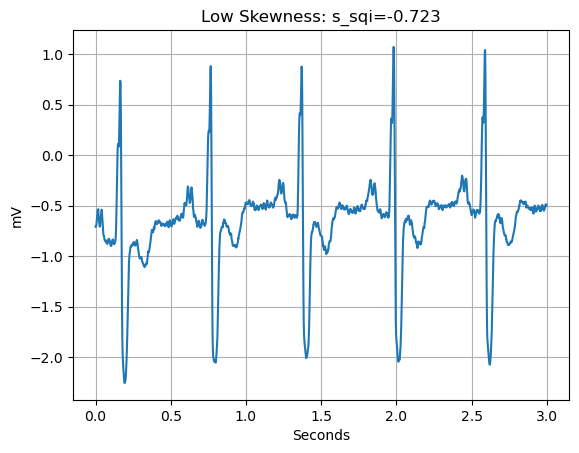

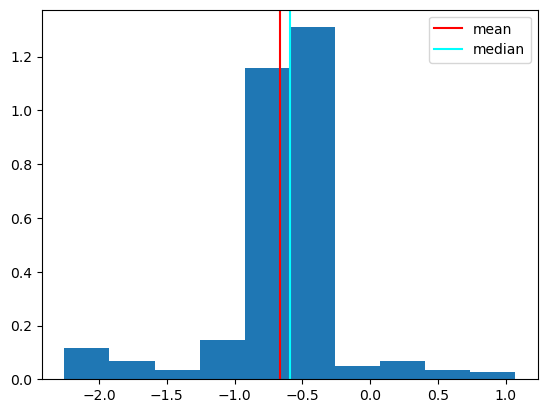

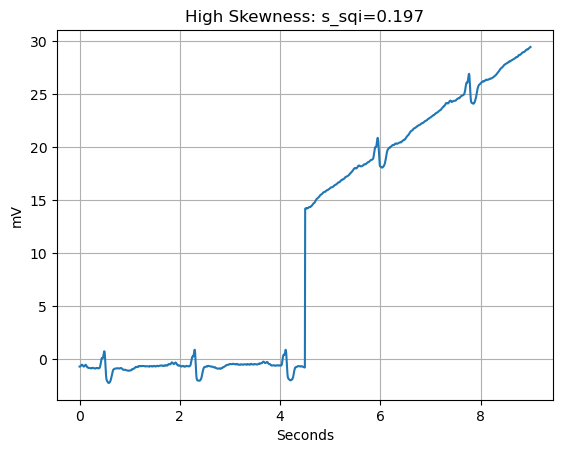

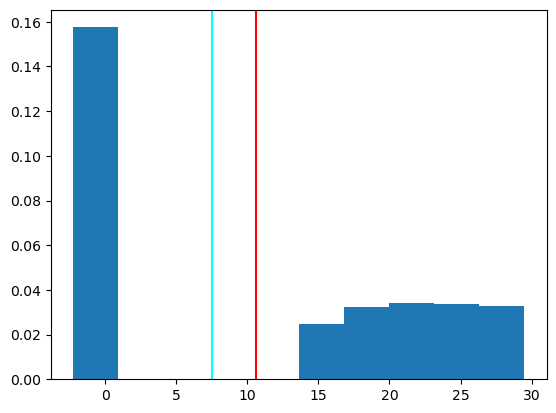

In [12]:
### Example of skewness in ECG signal

import wfdb
import matplotlib.pyplot as plt
import sys
import scipy.stats

mitdb_path = './data/mitdb/'
subject = '118'
subject_record = wfdb.rdrecord(mitdb_path+subject)
subject_data = subject_record.p_signal.transpose()

start = 51000
step = 500*3

plt.xlabel('Seconds'); plt.ylabel('mV')
plt.grid()
plt.plot(np.arange(step)/500, subject_data[0,start:start+step])
plt.title('Low Skewness: s_sqi={:.3f}'.format(scipy.stats.skew(subject_data[0,start:start+step])))
plt.show()

plt.hist(subject_data[0,start:start+step], density=True)
plt.axvline(x=np.mean(subject_data[0,start:start+step]), label='mean', c='red')
plt.axvline(x=np.median(subject_data[0,start:start+step]), label='median', c='cyan')
plt.legend(); plt.show()

noise_data = np.arange(step)/500*10
noise_data[:step//2] = 0
plt.xlabel('Seconds'); plt.ylabel('mV')
plt.grid()
plt.plot(np.arange(step)/500*3, subject_data[0,start:start+step]+noise_data)
plt.title('High Skewness: s_sqi={:.3f}'.format(scipy.stats.skew(subject_data[0,start:start+step]+noise_data)))
plt.show()

plt.hist(subject_data[0,start:start+step]+noise_data, density=True)
plt.axvline(x=np.mean(subject_data[0,start:start+step]+noise_data), label='mean', c='red')
plt.axvline(x=np.median(subject_data[0,start:start+step]+noise_data), label='median', c='cyan')

plt.show()


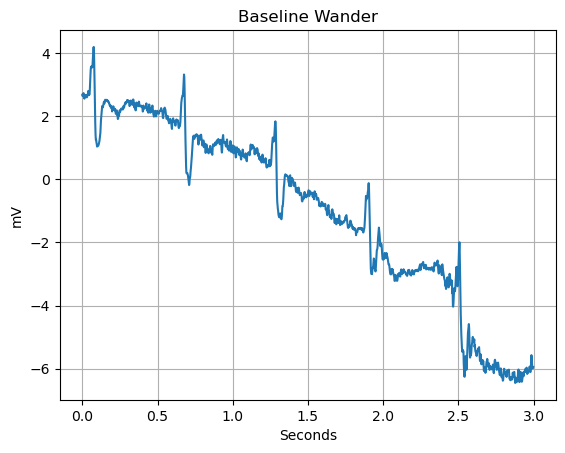

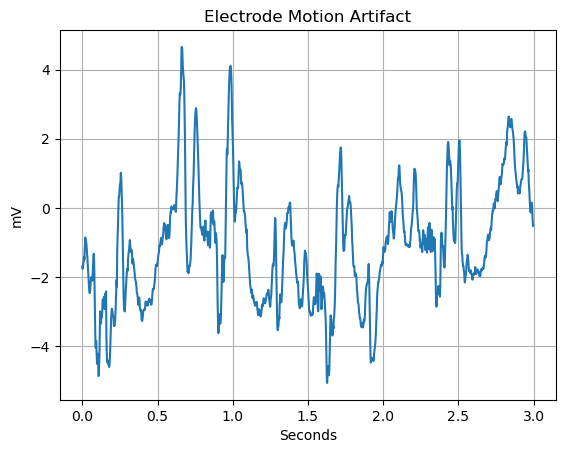

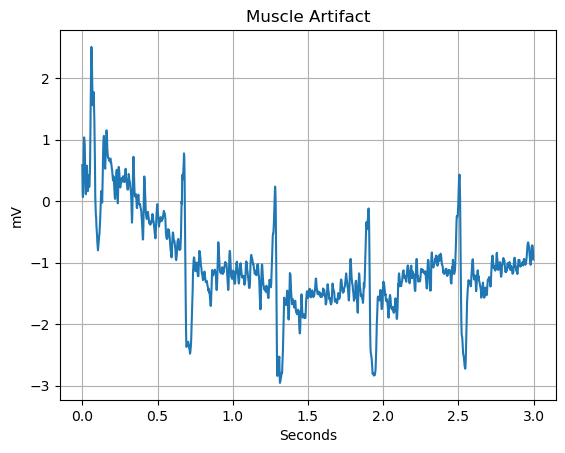

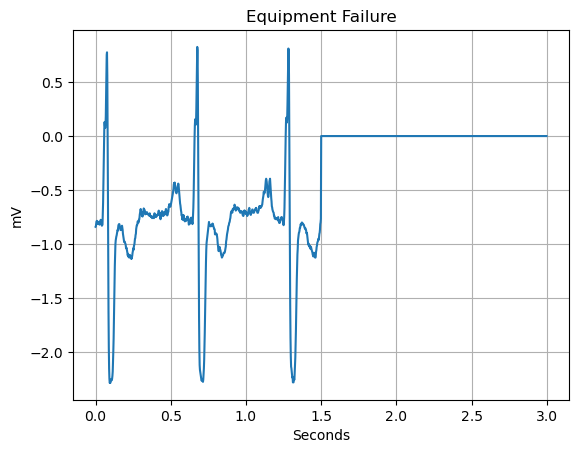

In [13]:
### Examples of types of noise Baseline Wander', 'Electrode Motion Artifact', 'Muscle Artifact

import wfdb
import matplotlib.pyplot as plt

subject = '118'
subject_record = wfdb.rdrecord(mitdb_path+subject)
subject_data = subject_record.p_signal.transpose()

start = 55000
step = 500*3

for noise_type, title in  zip(['bw', 'em', 'ma'],['Baseline Wander', 'Electrode Motion Artifact', 'Muscle Artifact']):

    noise_record = wfdb.rdrecord(nstdb_path+noise_type)
    noise_data = noise_record.p_signal.transpose()

    plt.title(title)
    plt.xlabel('Seconds'); plt.ylabel('mV')
    plt.grid()
    plt.plot(np.arange(step)/500,
             subject_data[0,start:start+step]+noise_data[0,start:start+step]*5)
    plt.show()


noise_data = -subject_data[0,start:start+step]
noise_data[:step//2] = 0
plt.title('Equipment Failure')
plt.xlabel('Seconds'); plt.ylabel('mV')
plt.grid()
plt.plot(np.arange(step)/500,
         subject_data[0,start:start+step]+noise_data)
plt.show()

(225694,)


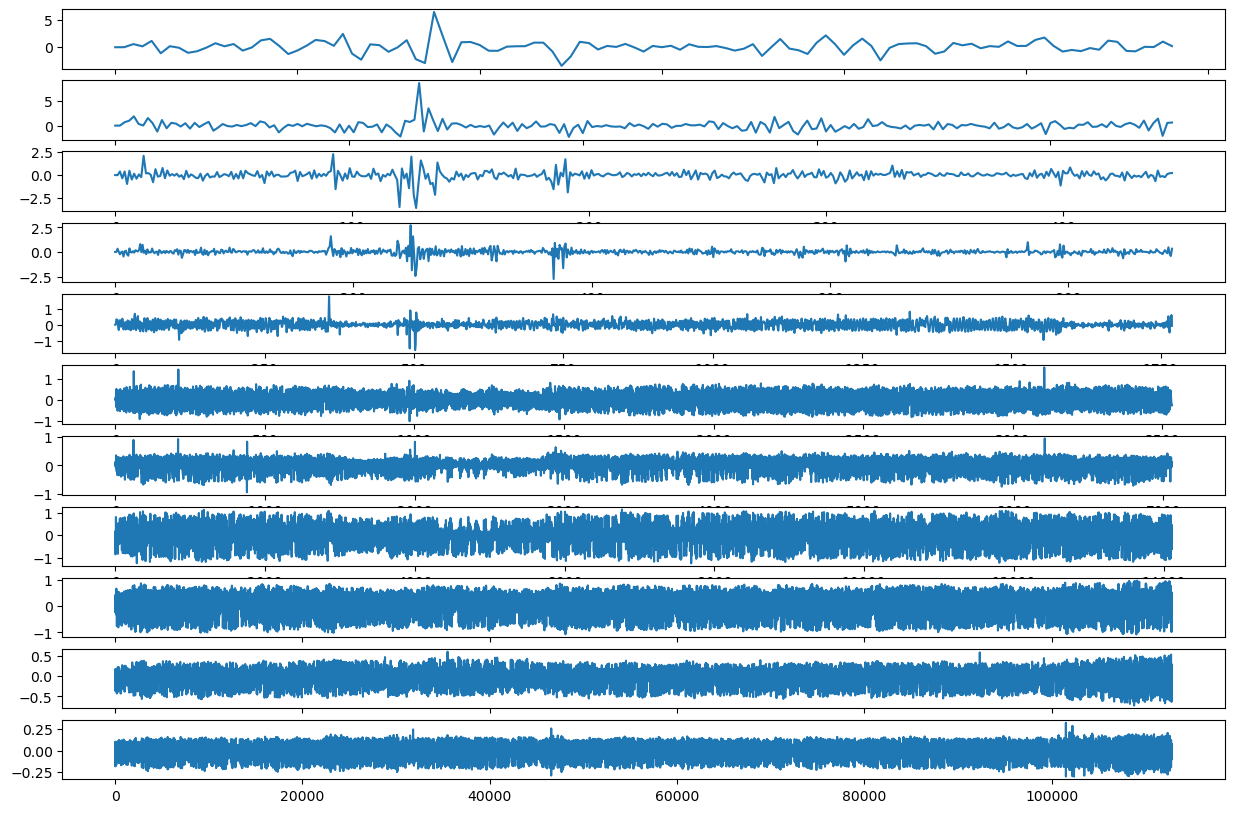

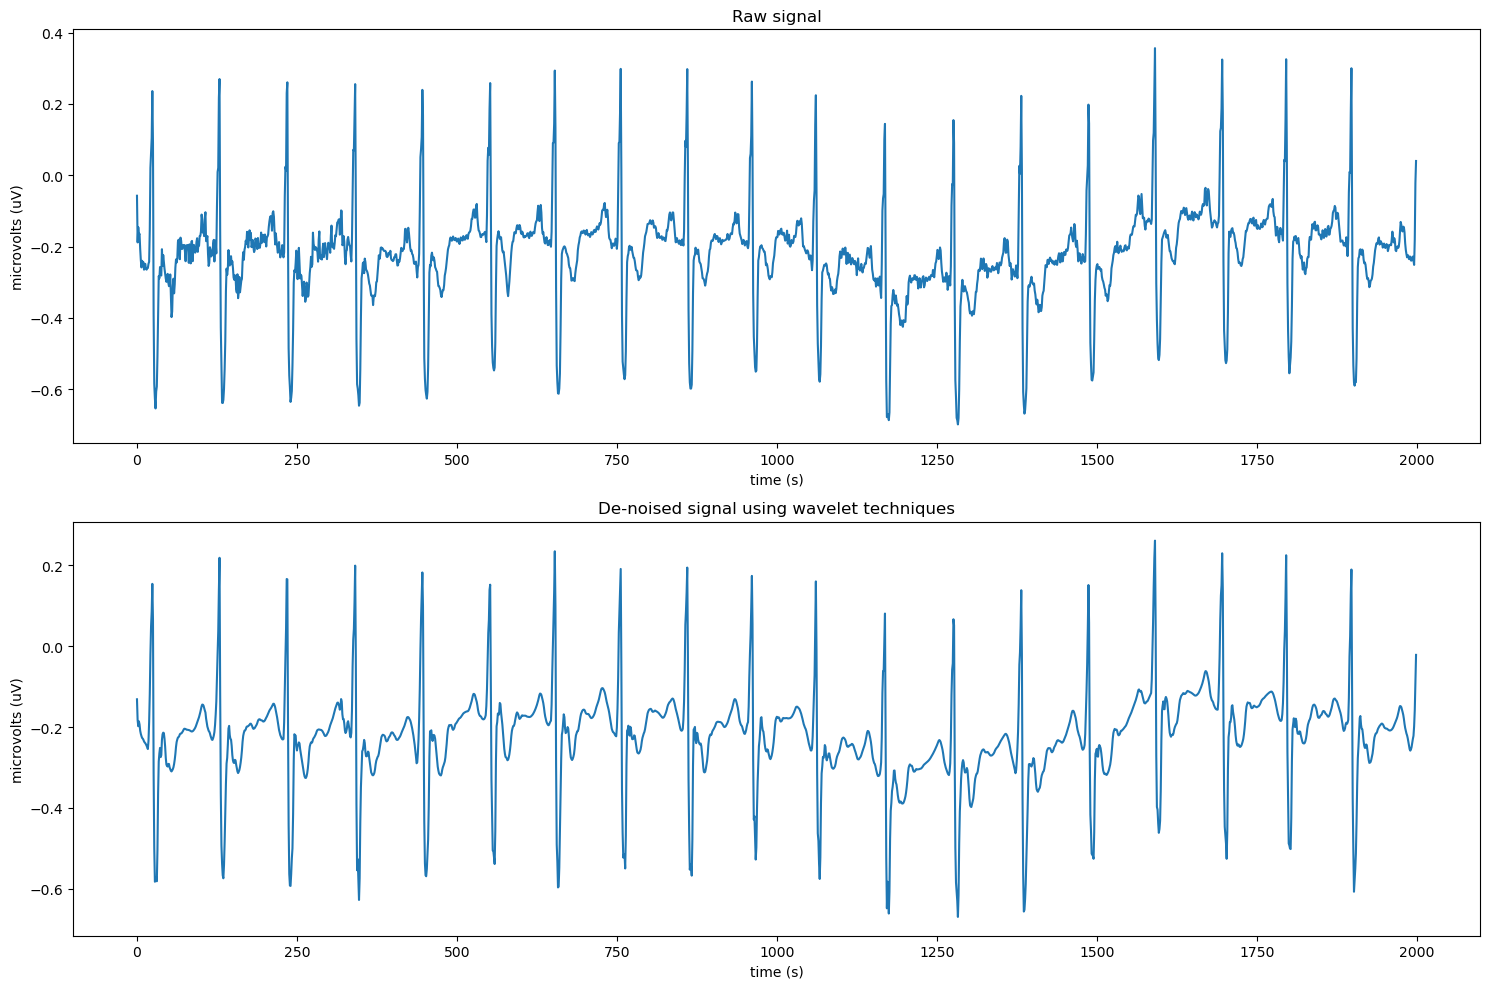

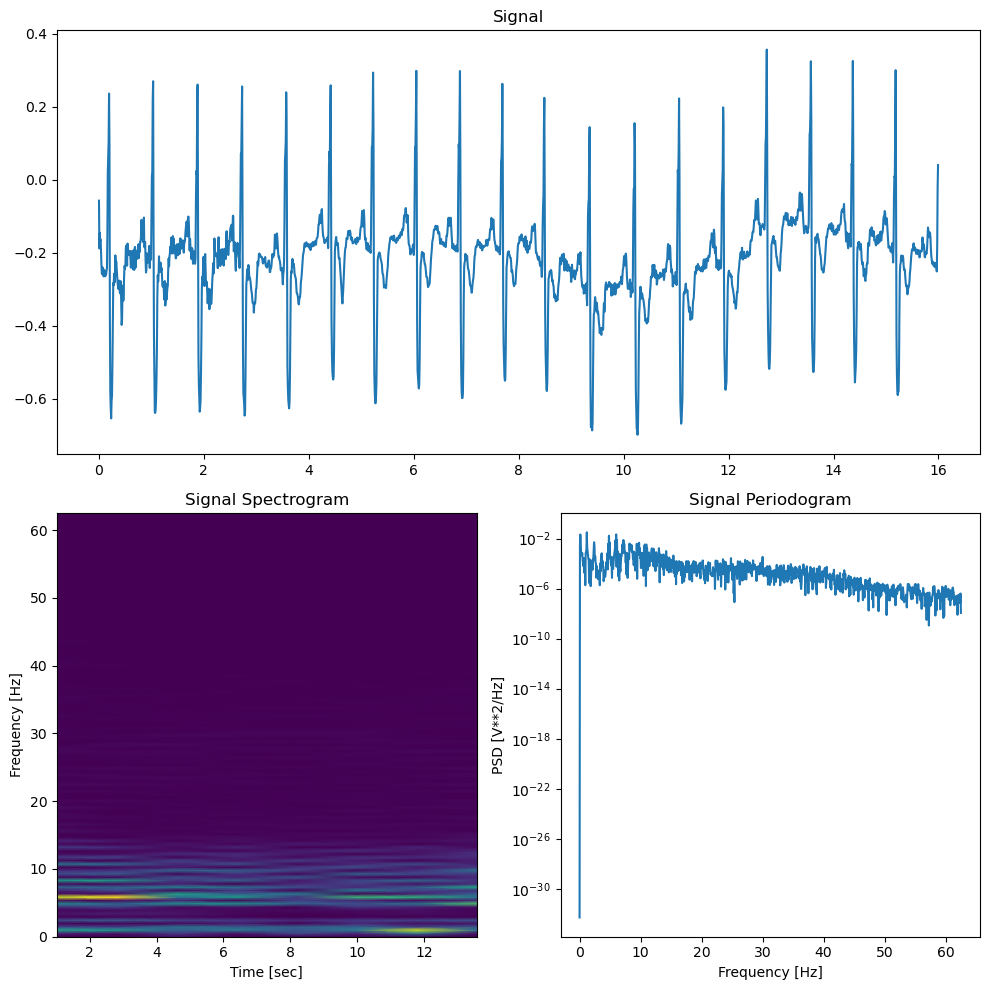

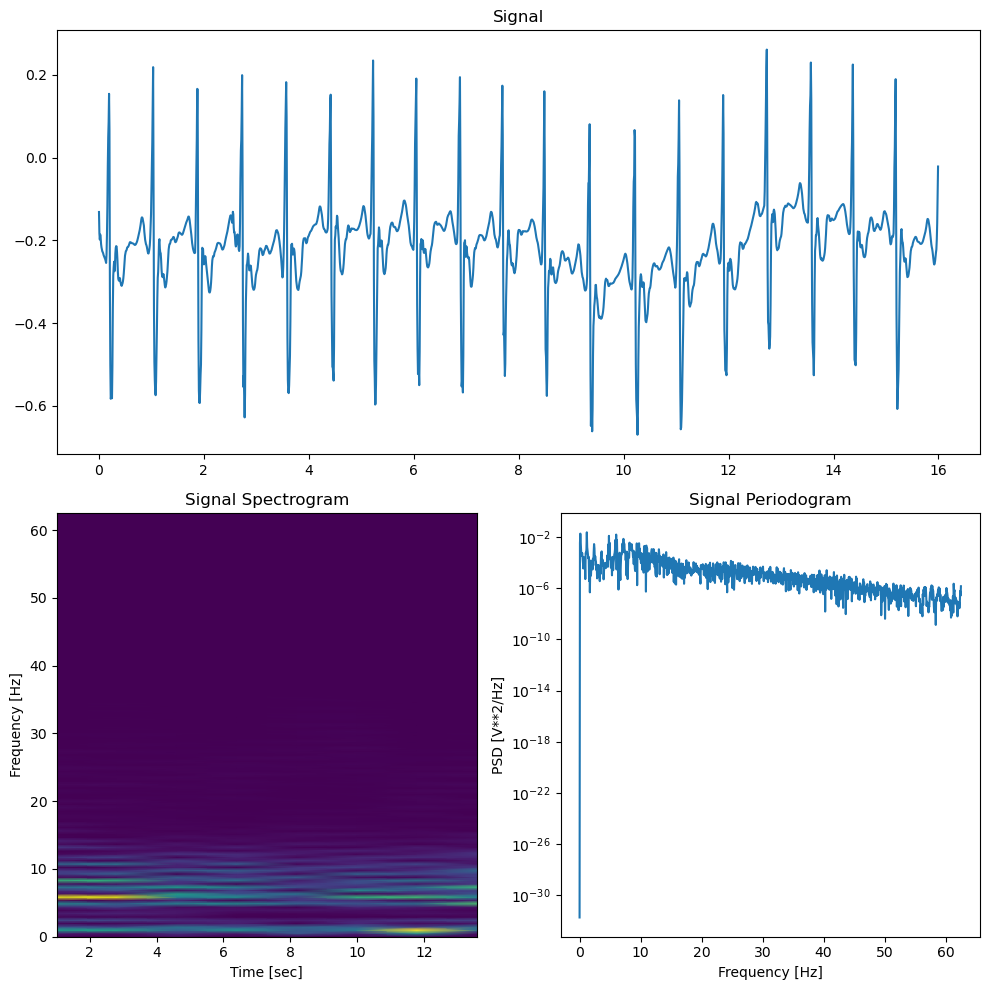

In [14]:
## Visualizing Wavelet Denoising
## Source: https://github.com/MProx/Wavelet-denoising

import matplotlib.pyplot as plt
importlib.reload(denoising)
import sys
import scipy

# output_dict
example_signal = mitdb_dict['118']['MLII']['data']
print(example_signal.shape)
index = np.arange(len(example_signal))

mintime = 0
maxtime = mintime + 1000

example_signal = denoising.rescale_signal(example_signal)
datarec = denoising.denoise_wavelet(example_signal, visualize=True)

mintime = 0
maxtime = mintime + 2000
plt.figure(figsize=(15,10))
plt.subplot(2, 1, 1)
plt.plot(index[mintime:maxtime], example_signal[mintime:maxtime])
plt.xlabel('time (s)')
plt.ylabel('microvolts (uV)')
plt.title("Raw signal")
plt.subplot(2, 1, 2)
plt.plot(index[mintime:maxtime], datarec[mintime:maxtime])
plt.xlabel('time (s)')
plt.ylabel('microvolts (uV)')
plt.title("De-noised signal using wavelet techniques")

plt.tight_layout()
plt.show()

plot_signal(example_signal[mintime:maxtime], fs=125)
plot_signal(datarec[mintime:maxtime], fs=125)

(2000,)


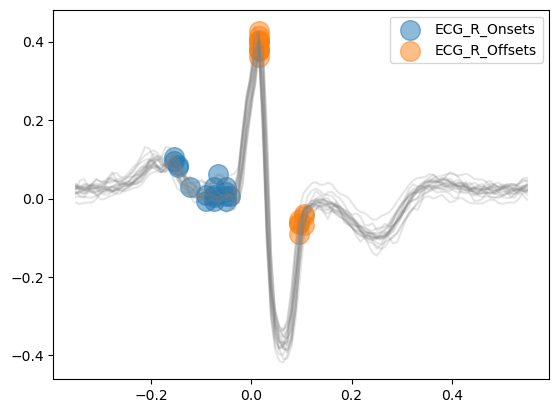

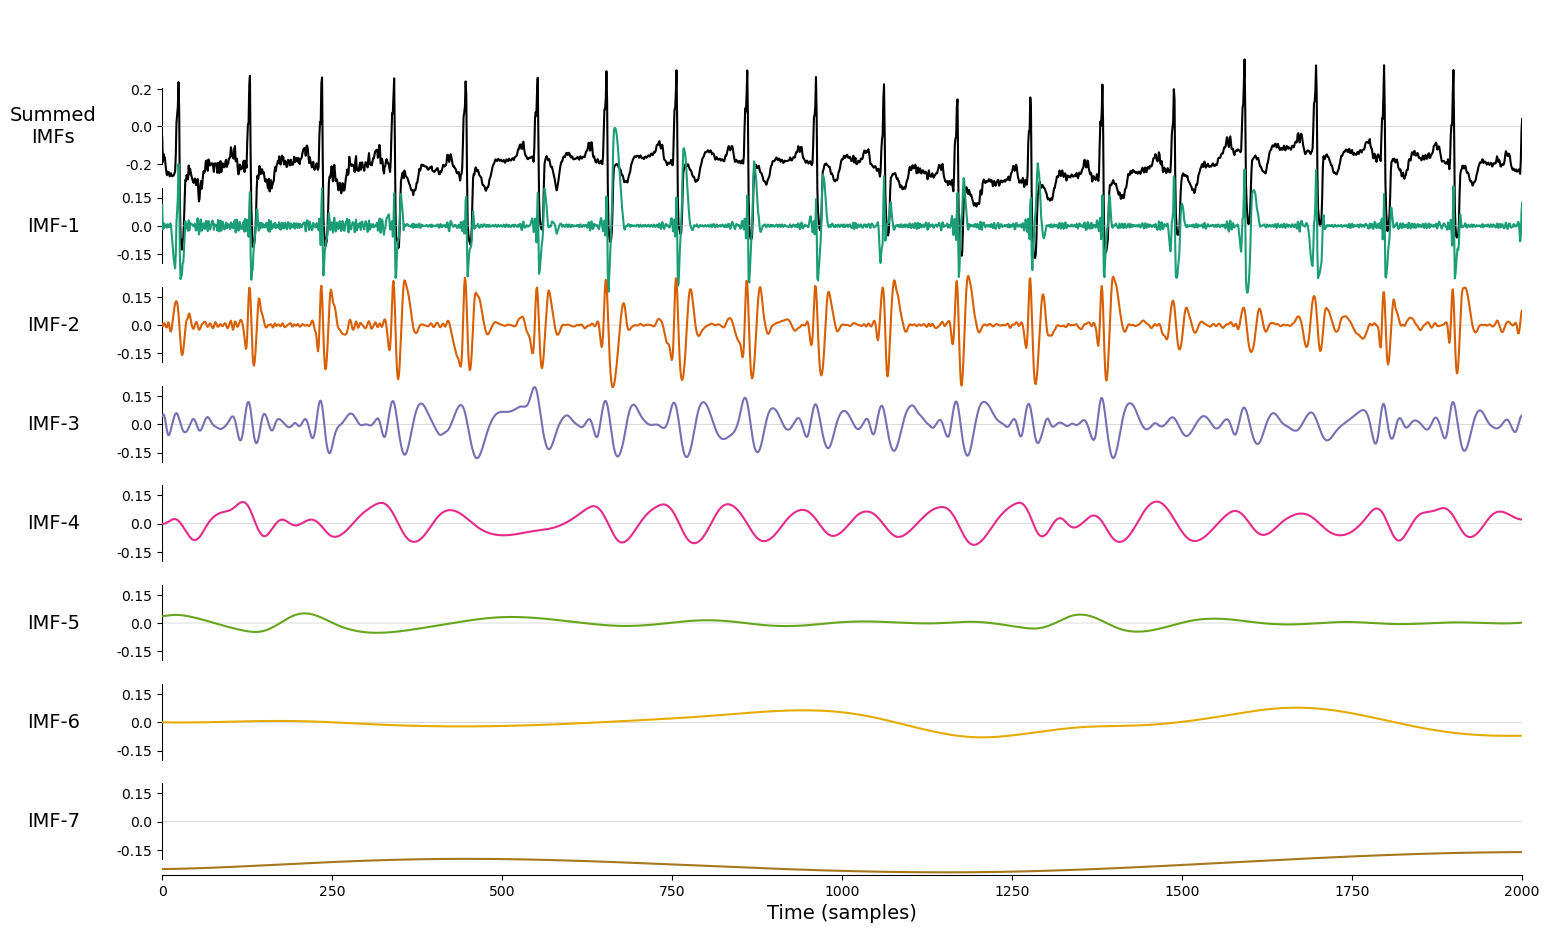

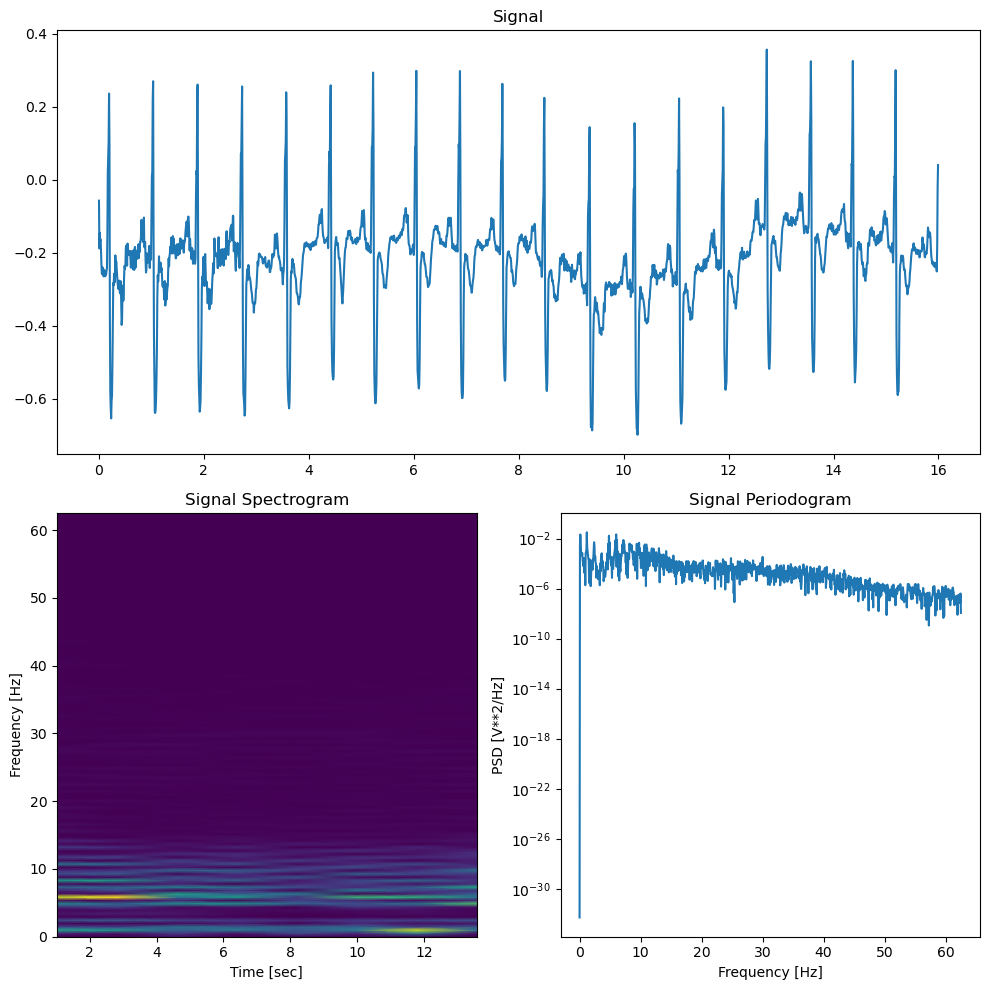

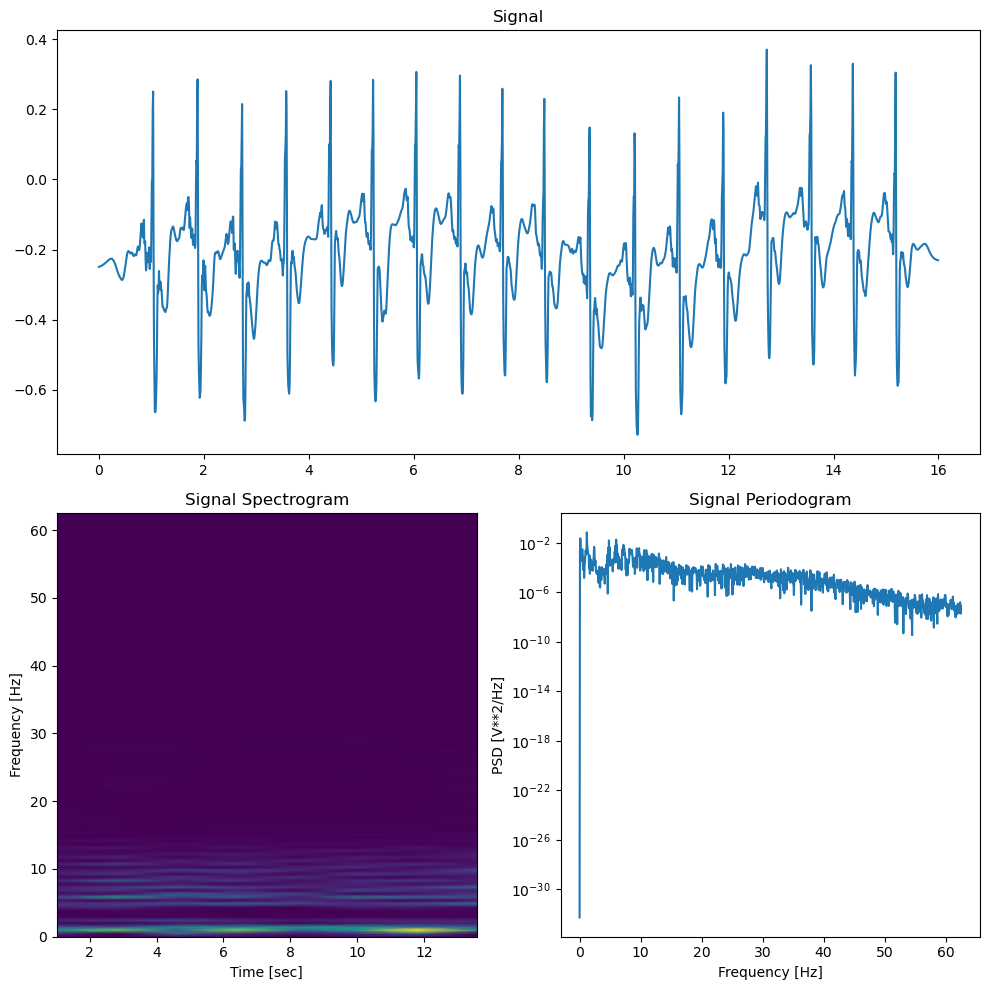

In [15]:
## Visualizing EMD Denoising

import matplotlib.pyplot as plt
import numpy as np
import emd
import neurokit2 as nk

datarec = denoising.denoise_emd(example_signal[mintime:maxtime], sample_rate=125, P=5, beta=300, visualize=True)

print(example_signal[mintime:maxtime].shape)
plot_signal(example_signal[mintime:maxtime], fs=125)
plot_signal(datarec[mintime:maxtime], fs=125)
